<a href="https://colab.research.google.com/github/drwbkr1/Grad504-K-Nearest-Neighbor-Classifier/blob/main/KNN_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#K-Nearest Neighbor: A Simple Classifier
In some machine learning problems, it's helpful to receive predictions on data samples without a heavily coded infrastructure. In cases like these, K-Nearest Nieghbor (KNN) makes for a handy tool in a pinch. Particularly when working with small to medium sized datasets, you can quickly apply a KNN classifier and receive an output. Handling both numerical and categorical data, a user simply needs to provide a cleaned up set to receive benchmark accuracy. Let's take a look at the inner workings of a rudimentary KNN algorithm, its strengths, weaknesses and ways to expand its capabilities.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import time
import warnings
from collections import Counter

## Data Types
The design behind this implementation highlights the abilities of KNN, specifically when applied to continuous data. Thus, I made the decision to work strictly with numerical items. This load function handles the initial feature-target split, converting their dataframes to ndarrays for better compute performance. It also does preliminary sanity checks to ensure relatively clean sets.

Specifically, note the warning before the X/y split. I chose to include a soft error for cases in datasets---such as the auto mpg set introduced later---where values are missing or categorical. I wanted users (not that anyone is using this) to have an opportunity to address these cases before fitting the training data to the model. And they can't do that if they can't get past the load function!

In [ ]:
#Any dataset is verified for basic parameters before preprocessing.
def load_csv(file):
  df= pd.read_csv(file)

  #Check for data in dataset, numerical features for supporting floating-point inputs
  if df.shape[1] < 2:
    raise ValueError("File must have at least one feature and a target")
  try:
    X_df= df.iloc[:, :-1].astype(float)
  except ValueError:
    warnings.warn("WARNING: Non-numerical datapoints (missing values or categorical) detected!")

  #Split dataset into features and target, dataframes to ndarrays.
  X= df.iloc[:, :-1].to_numpy()
  y= df.iloc[:, -1].to_numpy()

  #Check for feature-target congruency, feature congruency
  if not X.shape[0]==y.shape[0]:
    raise ValueError("Error: Features and target must have the same length")
  if not all(len(features)==len(X[0]) for features in X):
    raise ValueError("Error: All features must have the same length")

  return X, y

## K-Nearest Neighbor Algorithm
The next few codeblocks detail the elements of the KNN algorithm. Compared to other machine learning methods, K-nearest neighbor has a surprisingly simple structure:
1. Store the training examples.
2. Calculate k-nearest datapoints based on a distance measure.
3. Assign class prediction based on most common among neighbors.

Because of its simplicity, KNN makes for a quick yet reliable classifier when using numerical datasets. However, due to its high number of computations---(n training samples) X (d features) X (m test samples)---it starts to struggle with high-dimentional problems. Performance continually drops when introducing categorical features, as the distance measure gets a little more complex.

Let's take a closer look at the components that enable a rudimentary KNN classifier.


### KNN Model Instance
The foundation of this KNN implementation lies in its Euclidean Distance method. This tool receives a training sample and test sample, collects the sum of all their squared feature differences and finds its square root. The calculation outputs a distance that correlates to the cumulative features.

As mentioned above, other KNN designs can handle categorical data using another measurement tool. Particularly, Jaccard Distance assumes qualitative items have been converted to a numerical counter(binary, ordinal, one-hot encoding) that can be tallied. However, this version does not include this feature, thus is not the place for a deeper explanation.

The adjacent KNN classifier method does just as the name implies---classifies the test sample. It utilizes the distance method, pairing the calculation output with the class associated to the inputted training item. The resulting tuple might look something like (5.12, '+').

This classifier will do that for every single training sample in the training set. When it's finished, it organizes them from lowest distance to highest (representing the classes 'nearest' to the test sample). At this point, the 'k' in k-nearest neighber comes in; the classifier segments the top 'k' training samples--that could be 3 if k=3 or 10 if k=10 and so on---and returns the most common class among them.

While that might feel like a lot of work, the real kicker lies in the predict method; this tool is going to run that same classifier for the entire index of test samples. When it finishes, we have our output of predictions.

In [ ]:
#Establish the model class to create new instance for any dataset. Includes classifier mechanics and fit/predict methods
class KNNClassifier:
  def __init__(self, n_neighbors): #Creates an instance of the KNNClassifier
    self.k= n_neighbors
    self.X_train= []
    self.y_train= []

  def fit(self, X_train, y_train): #Receives training split, fit it to KNN instance
    self.X_train= X_train
    self.y_train= y_train

  def euclidean_distance(self, X_test, X_train): #Standard distance formula
    distance= np.sqrt(sum((X_testi - X_traini)**2 for X_testi, X_traini in zip(X_test, X_train)))
    return distance

  def KNN_classifier(self, X_test): #Gathers all distances from a test point, orders them by size
    distances= [(self.euclidean_distance(X_test, X_train), label) for X_train, label in zip(self.X_train, self.y_train)]
    distances.sort(key=lambda x: x[0])
    k_neighbors= [label for _, label in distances[:self.k]] #selects closest train points, assigns most common class
    return Counter(k_neighbors).most_common(1)[0][0]

  def predict(self, X_test): #Utilizes KNN_classifier method to create a list of predicted classifiers
    return [self.KNN_classifier(x) for x in X_test] #This is where the model loops over each row in the test set

### Validation
Determining how to validate the KNN implementation wasn't so clear at first; As demonstrated below, this classifier does an excellent job making predictions on numerical data. So good is its prediction that a novice developer might be concerned and try a cross validation for a more humble error. However, that novice developer needs to remember: as many computations as KNN is going to make, a cross validation will have it do them a number of folds more.

Therefore, choosing the right validation method could require a heuristic approach, possibly even visualizing the data. I think a good rule of thumb might be: the cleaner the data, the easier the validation. If one were to apply KNN to a dataset with much more noise, it may be worth the time to standardize or reduce dimensions.

In [ ]:
def train_test_split(X, y, train_frac= .1): #randomizes index, splits index at percentage, assigns split indexes to train and test arrays.
  rng= np.random.default_rng(seed= 0)
  shuffled_idx= rng.permutation(len(X))
  n_train= int(len(X) * train_frac)

  train_idx= shuffled_idx[:n_train]
  test_idx= shuffled_idx[n_train:]

  X_train= X[train_idx]
  y_train= y[train_idx]
  X_test=X[test_idx]
  y_test= y[test_idx]
  return X_train, y_train, X_test, y_test

### Fitting the Instance
Assuming our rudimentary data structure, our K-Nearest Neighbor algorithm only requires a basic fitting. Contrary to the term, KNN doesn't really do any 'machine learning.' Instead it's going to load the entire training set in preparation for the numerous computations it will make when given a comparative test set. By design, the fitting is practically effortless.

In [ ]:
def KNN_fit_pred(k= 5): #assigns model instance, fits training data, predicts on test data
  model= KNNClassifier(n_neighbors= k)
  model.fit(X_train, y_train)
  predictions= model.predict(X_test)
  return predictions

## Testing the Model
Okay, let's get into loading the datasets and testing the K-Nearest Neighbor algorithm. For practicality in this project, I chose to move the datasets further down the script. It just let me trade them out in my load_csv function with minimal effort. The datasets used in this project include: 1. the course dataset, 2. the Iris dataset, and 3. the Auto_MPG dataset.



### Load the Datasets
In the next two codeblocks, I load the course set and the Iris dataset, known for its unique qualities including
- float points
- multiple classes (making it nonbinary)

As demonstrated, the load function has no problem with with either dataset and throws no errors.

In [ ]:
#The list of datasets used during the project
course= ("/content/drive/MyDrive/Colab Notebooks/datasets/Prog1data.csv") #The required dataset
iris= ("/content/drive/MyDrive/Colab Notebooks/datasets/Iris.csv") #dataset w/ float points and multiple classes
autos= ("/content/drive/MyDrive/Colab Notebooks/datasets/auto-mpg.csv") #dataset to trigger missing data error handling

#Just copy/paste the desired variable into the load_csv parameter
X, y= load_csv(course)
for i in range(3):
  print(X[i], y[i])
print(X.dtype, y.dtype)

[ 8  9  0 26 10 25  7 68  2  7 10] +
[ 8  8  0 23  9 15  5 70  3  7 10] +
[11  3  6 19  8 17  6 80  2  6 10] +
int64 object


In [ ]:
X, y= load_csv(iris)
for i in range(3):
  print(X[i], y[i])
print(X.dtype, y.dtype)

[1.  5.1 3.5 1.4 0.2] Iris-setosa
[2.  4.9 3.  1.4 0.2] Iris-setosa
[3.  4.7 3.2 1.3 0.2] Iris-setosa
float64 object


I also chose to load a classic training set---Auto-MPG---which takes a variety of features to predict fuel efficiency for a vehicle. One of the features (horsepower) has unknown values, and should trigger the warning in the load function as described earlier.

As designed, the user can still load the data but knows to preprocess the categorical features for the model before fitting.

Generally, empty datapoints are filled by default with a variety of indicators (eg. '?', 'NAN', 'Unknown', etc.) because these are natively categorical, empty items should trigger the same warning.

*Note: The structure of the Auto_MPG dataset did not align with the load function, accidentally naming the car model feature as the target. An important lesson in viewing the data structure beforehand but the example I was making still stands.*

In [ ]:
X, y= load_csv(autos)
for i in range(3):
  print(X[i], y[i])
print(X.dtype, y.dtype)

[18.0 8 307.0 '130' 3504 12.0 70 1] chevrolet chevelle malibu
[15.0 8 350.0 '165' 3693 11.5 70 1] buick skylark 320
[18.0 8 318.0 '150' 3436 11.0 70 1] plymouth satellite
object object


/tmp/ipython-input-152-537932513.py:11: UserWarning: WARNING: Non-numerical datapoints (missing values or categorical) detected!
  warnings.warn("WARNING: Non-numerical datapoints (missing values or categorical) detected!")


### Fit/Predict
In the example below, I loaded the course dataset to the KNN instance. I split the data at 70% training, 30% test. I chose a modest split in this example to demonstrate just how effective KNN works with purely numerical data. All it needs to do is feed the datapoints through the algorithm and output the result.

Accuracy: 0.983


<Axes: xlabel='Predicted', ylabel='Actual'>

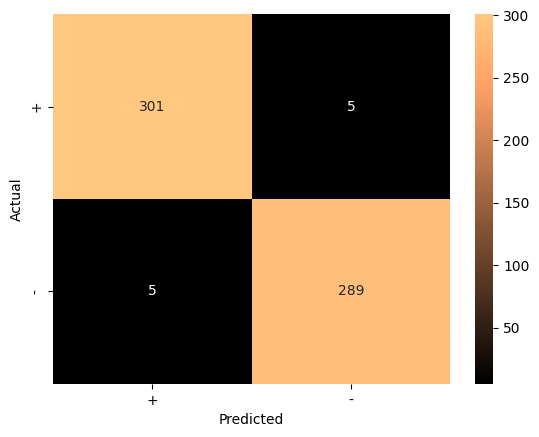

In [ ]:
#The primary codeblock for testing/validating predictions
X_train, y_train, X_test, y_test= train_test_split(X,
                                                   y,
                                                   train_frac= .7) #Adjust train/test split here

predictions= KNN_fit_pred(k=5) #Adjust k here
correct= sum(p==a for p, a in zip(predictions, y_test))
total= len(y_test)
accuracy= correct/total

print(f'Accuracy:{accuracy: .3f}')

#Let's see what the predictions look like in a Confusion Matrix
cm = pd.crosstab(y_test,
                 predictions,
                 rownames=['Actual'],
                 colnames=['Predicted'])

sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="copper")

Even with a liberal split like the example above, this rudimentary KNN model predicted the test data at over 98% accuracy. As this is my first model I've ever written, I was naturally concerned. It led me to multiple tests, including a t-SNE visualization (not portrayed) and some ridiculous splits as you'll see below.

For both the course and Iris datasets, I chose to use an accuracy error metric. Generally, we want to pair this measurement with other scales, increasingly so as classes become more unevenly distributed. However for these particular sets, the classes are uncharacterictically balanced. Iris features three classes with 50 entries each, and the course set may have an imbalance of two or three out of 1999 entries. Thus, I considered Occam's Razor. In unique cases like these, its best to keep things simple.

## Error Handling: Acknowledging the Strangeness
Even with extemely clean datasets such as these, a user is bound to run into some anomalies. Below I demonstrate some of the inconsistencies I discovered as I wrote this algorithm and what I think they mean.

### Noise: Bias or Variance?
In this example, I run a second test of the KNN model using the course dataset. As noted in the train/test split, I use an uncommonly low split point, bound to cause underfitting in any other case.

Accuracy: 0.964


<Axes: xlabel='Predicted', ylabel='Actual'>

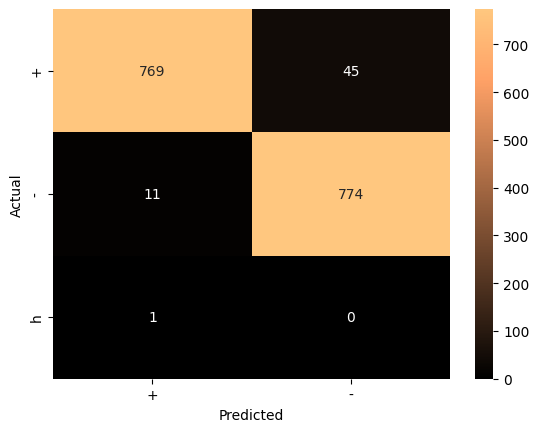

In [ ]:
X_train, y_train, X_test, y_test= train_test_split(X,
                                                   y,
                                                   train_frac= .2) #Adjust train/test split here

predictions= KNN_fit_pred(k=5) #Adjust k here
correct= sum(p==a for p, a in zip(predictions, y_test))
total= len(y_test)
accuracy= correct/total

print(f'Accuracy:{accuracy: .3f}')

#Let's see what the predictions look like in a Confusion Matrix
cm = pd.crosstab(y_test,
                 predictions,
                 rownames=['Actual'],
                 colnames=['Predicted'])

sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="copper")

As we can see, the model still scores over 96% accuracy in its predictions, testifying mainly to the predictability of the algorithm and the cleanliness of the dataset. However, it seems to have predicted one class entirely wrong; the KNN instance predicted '+' when it should have predicted 'h'

wait... 'h'?

the first time I caught this, I thought I had accidentally manipulated the dataset by accident when I first viewed it and had to download it again to confirm. Yeah, one of the instances is classified as 'h', making the course dataset a multiclass problem, checking off one of the optional implementations. Woo Hoo!

But in all seriousness, this does introduce some interesting questions. Is this instance actually an 'h' class? Was this class entry a typo? Is there a systematic error in the way this data was collected?

Largely--and I'll mention it a couple more times---it's hard to tell with featureless metadata. If this was Iris and we had 50 'Iris-setosa', 50 'Iris versicolor', 49 'Iris virginica', and 1 'h', one might quickly infer a typo. Or let's say we had a multiclass problem that used an alphabetical scale (a,b,c,d,etc...). Would that scale stop at 'g' or 'h'? What if it skipped letters? What if it was classifying musical notes? At the end of the day, knowing the domain of the dataset helps us understand the context of our classes.

One thing that we can do, even with featureless metadata, is increase the number of instances. If we could expand the course data from 2000 to 10000, would we still only have one point? Or would we have a small cluster of 5 'h' classes? Generally, machine learning can handle variance but becomes skewed with bias.

### When K is greater than N
As k approaches n, the model becomes less expressive and decision boundaries become smooth. Continue increasing k and we see predictions encapsulating entire portions of the dataset. By the time a prediction reaches k=n, the model will have chosen every entity, essentially resulting in any prediction representing the majority class. But what happens if k is even higher than that?

In the example below, I split the Iris dataset 80/20, which corresponds to about 120 entities. Then I set k to 125, a larger quantity than the training set. Here's how it responds:

In [ ]:
X_train, y_train, X_test, y_test= train_test_split(X,
                                                   y,
                                                   train_frac= .8) #Adjust train/test split here

predictions= KNN_fit_pred(k=125) #Adjust k here
correct= sum(p==a for p, a in zip(predictions, y_test))
total= len(y_test)
accuracy= correct/total
print(predictions[:5])
print(f'Accuracy:{accuracy: .3f}')

['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa']
Accuracy: 0.267


The outcome was more of what I could have expected than I did. I think initially I was waiting for the model to throw an error, but it seems to treat it the same as k=n.

We can still talk about why the accuracy score is lower than expected; with an even class distribution in the Iris dataset, a baseline might sit at around 33%. However, this has everything to do with the random train/test splitting. In an ideal world, the training set would come out balanced. However, this is the real world, and a random split better represents a true outcome. If we really wanted to, we could a cross validation and take the mean, but there's not really a scenario where we use this example outside of a graduate course.

### Tie Breakers
When I first tested my algorithm, I used a variety of k values---from 1 to 100. In common practice, its easiest to use an odd value; that way, the model always have a majority class at the final count. But when I tested a variety of numbers, including evens, I always received an output; that had me curious.

Having thought about this problem for some time (and seeing the t-SNE visualization), I've come to understand that because the classes are so distinct, there would have been a near improbability that a test in this dataset would have presented a tie.

However, I've already done the test for tie breakers, so let's see how the model would handle one in a set not nearly as clean.

In [ ]:
#A very rudimentary test to see how the model handles tie breakers
tie_train_X= [[1,1], [1,1]], [[1,1], [1,1]], [[1,1], [1,1]], [[1,1], [1,0]]
tie_train_y=   [['+','-'],     ['A', 'B'],     ['B', 'A'],     ['B', 'A']]

tie_test_X= [[0,0]]

for X, y in zip(tie_train_X, tie_train_y):
  X_train= X
  y_train= y
  X_test= tie_test_X

  tie_predictions= KNN_fit_pred(k=2) #k as 2 forces it to choose one of the two training points
  print(tie_predictions)


['+']
['A']
['B']
['A']


The test above sets four comparisons. The first three include only two equal points, and the fourth features two points with one closer than the other.

I gave the first comparison points classes similar to the course data. In a KNN classification where k=2 (resulting in the model choosing only one external point), the classifier chose '+'. Why?

In the second test, I just changed the classifiers. the model chose 'A'. Was it because it was alphabetical in nature? In the third test, I swapped those classifiers; it chose 'B'. Nope, it's probably just choosing the first index in case of a tie.

In the fourth test, I gave the second point a closer distance. this time the model predicted 'A', correlating with that second entity. Everything's working, and in events of tiebreakers, it defaults to the earlier index.

So what are the implications for this? Again, it really comes down to domain. In a featureless metadata set like this, this quirk is inconsequential. In a dataset where predictions have major consequences, such as malignant or benign cancers, one might want to weigh heavier a false alarm.

## Efficiency Limitations
Let's finish this up with one of KNN's most glaring drawbacks---its computational inefficiency at high volume. As stated earlier, it takes almost no effort to load a training set into the algorithm. However, as soon as it receives a test, it's going to calculate the distance between all of the points. Remember, there's no real learning, so it's brute forcing predictions using:

(number of training instances) x (the number of features) x (the number of test instances)

In this test, I ran model instances using increasingly large model samples. I collect the sample size (bytes) and the average time it takes (seconds) to finish predictions. the results are presented below.

In [ ]:
#Codeblock for compiling performance metrics (data size, compute time)
step_sizes= [100, 200, 300, 500, 600, 700, 1000, 1500, (len(X) - 1)]
rows= []
memories= []
times= []

for n_rows in step_sizes: #Testing the model on samples of the dataset that match the step sizes above
  if n_rows > len(X): #mainly if testing smaller datasets than the step sizes listed (Iris)
    break

  X_subset= X[:n_rows] #Looping with these subsets (Eg X_subset= X[1:100]...X[1:1500]...)
  y_subset= y[:n_rows]
  size= X_subset.nbytes + y_subset.nbytes #This is where it collects the byte size of the subsets

  X_train, y_train, X_test, y_test= train_test_split(X_subset,
                                                     y_subset,
                                                     train_frac= .8)

  n_repeats= 3 #for timing, test each subset n times and get an average
  total_elapsed= 0.000
  for _ in range(n_repeats):
    t0= time.time()
    KNN_fit_pred()
    t1= time.time()
    total_elapsed += (t1 - t0) #the n iterations add to total_elapsed from above

  avg_time= (total_elapsed / n_repeats) #the mean time

  rows.append(n_rows) #for each loop through the sample sizes,
  memories.append(size) #the metrics are added to their respective lists at the top
  times.append(avg_time)

data= [rows, memories, times]
table= pd.DataFrame(data).T #.T transposes the data list to make it legible in a dataframe table
table.columns= ['Rows', 'Memory (bytes)', 'Time (sec)']
table

,Rows,Memory (bytes),Time (sec)
0,100.0,9600.0,0.017301
1,200.0,19200.0,0.074095
2,300.0,28800.0,0.132072
3,500.0,48000.0,0.380693
4,600.0,57600.0,0.534283
5,700.0,67200.0,0.925015
6,1000.0,96000.0,2.145096
7,1500.0,144000.0,4.214377
8,1998.0,191808.0,6.845496


For context of these scores, I'm running this test locally on a workstation with 1.8GHz clockspeed and 32GB of RAM. The dataset at its max comes out to just below 200KB, so I was never in a range of maxing out memory. Even still, I ran into a wait time of nearly 7 seconds at only 1998 entities split and 11 features.

What does this mean if I needed a prediction in real time? To complete the function in about half a second, I could only load about 600 entities split.

Some back-of-the-napkin math for the project requirement. Let's say I have the same generation workstation, but it's 5GHz instead of 1.8GHz. Assuming all other components are relative, this faster workstation results in:

5GHz/1.8GHz = 2.8x quicker computation.

Okay, so if my computer can run a rudimentary KNN algorithm using 600 entities and 11 features in 0.5s, a workstation with 5GHz and 128GB RAM should be able to handle about 1700 entities split and 11 features in the same time. Wow, that's almost the entire course dataset!

Still, what if a user is working with data including tens of thousands of entities? This is pretty common in the real world. Does KNN make sense for any practical application at this scale?

## Final Thoughts and Considerations
In this project, I demonstrated the strengths and weakness of the K-Nearest Neighbor algorithm as it handles purely numerical data and binary classifiers. The model is incredibly easy to set up, only taking a couple parameters. And with properly cleaned data, one can receive surprisingly accurate predictions.

However, KNNs trade their accuracy for high computations. Instead of learning weights and applying its learning to test sets, it painstakingly calculates each distance. For any time sensitive problem, a developer may be hard pressed to use this model.

Additionally, KNNs are susceptible to irrelevant attributes as well as noise. If it weren't for the incredibly clean practice sets, my algorithm may not have performed well. Additionally, if it had any more features, both efficiency and accuracy would have crumbled.

After working with this model and dataset, I might like to experiment with a simple perceptron. This ANN works exceedingly well under the same conditions (numerical, clean, binary classes), except it handles its heavy computation at fitting instead of at prediction. So while it would have taken upwards to 8 seconds for the algorithm to receive the training set, its predictions would have finished notably quicker. The beautiful thing about this idea is that you can predict over and over again so long as that data is still fitted to the model.

Beyond the idea of switching models altogether, I also considered a couple of tactics for improving efficiency. If we stripped all of the restrictions of this project, It might be worth testing a principle component analysis (PCA) to determine which features were the most relevant and which provided the least information. Even lowering the dimensionality by a couple of features could have made a considerable difference in efficiency.

Now, if I had more time, I may have considered standardizing the dataset. While this does nothing directly to improve efficiency, it would ensure that all continuous points were on the same unit of measurement, increasing accuracy. And as we saw in the test, the cleaner the model, the less training data needed. And when training data reduces, the model has fewer calculations to do. In this indirect way, normalizing could have an influence on efficiency.